In [ ]:
import matplotlib.pyplot as plt

from utils import data_loader
from utils import model

import os
import sys
import pathlib

import numpy as np

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import expand_labels
from scipy.ndimage import gaussian_filter
from skimage import measure


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


ROOT_PATH = str(pathlib.Path().absolute())
DATA_STORAGE_PATH = '/data_storage/'
STORAGE_PATH = ROOT_PATH + DATA_STORAGE_PATH

DATASET_PATH = '/datasets/final_data'
FINAL_DATASET_PATH = ROOT_PATH + DATASET_PATH

TRAIN_PATH_IMAGES = FINAL_DATASET_PATH + '/train/images/'
TEST_PATH_IMAGES = FINAL_DATASET_PATH + '/test/images/'
VALI_PATH_IMAGES = FINAL_DATASET_PATH + '/validation/images/'

TRAIN_PATH_MASKS = FINAL_DATASET_PATH + '/train/masks/'
TEST_PATH_MASKS = FINAL_DATASET_PATH + '/test/masks/'
VALI_PATH_MASKS = FINAL_DATASET_PATH + '/validation/masks/'

In [8]:
image = imread('./examples/Image3759.jpg')[:, :, :1]
image_original_size = image.shape
density_amount, mask = model.predict('./model_checkpoints/model_unet_checkpoint_08_10_2022_024605.h5', image)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


30.378546


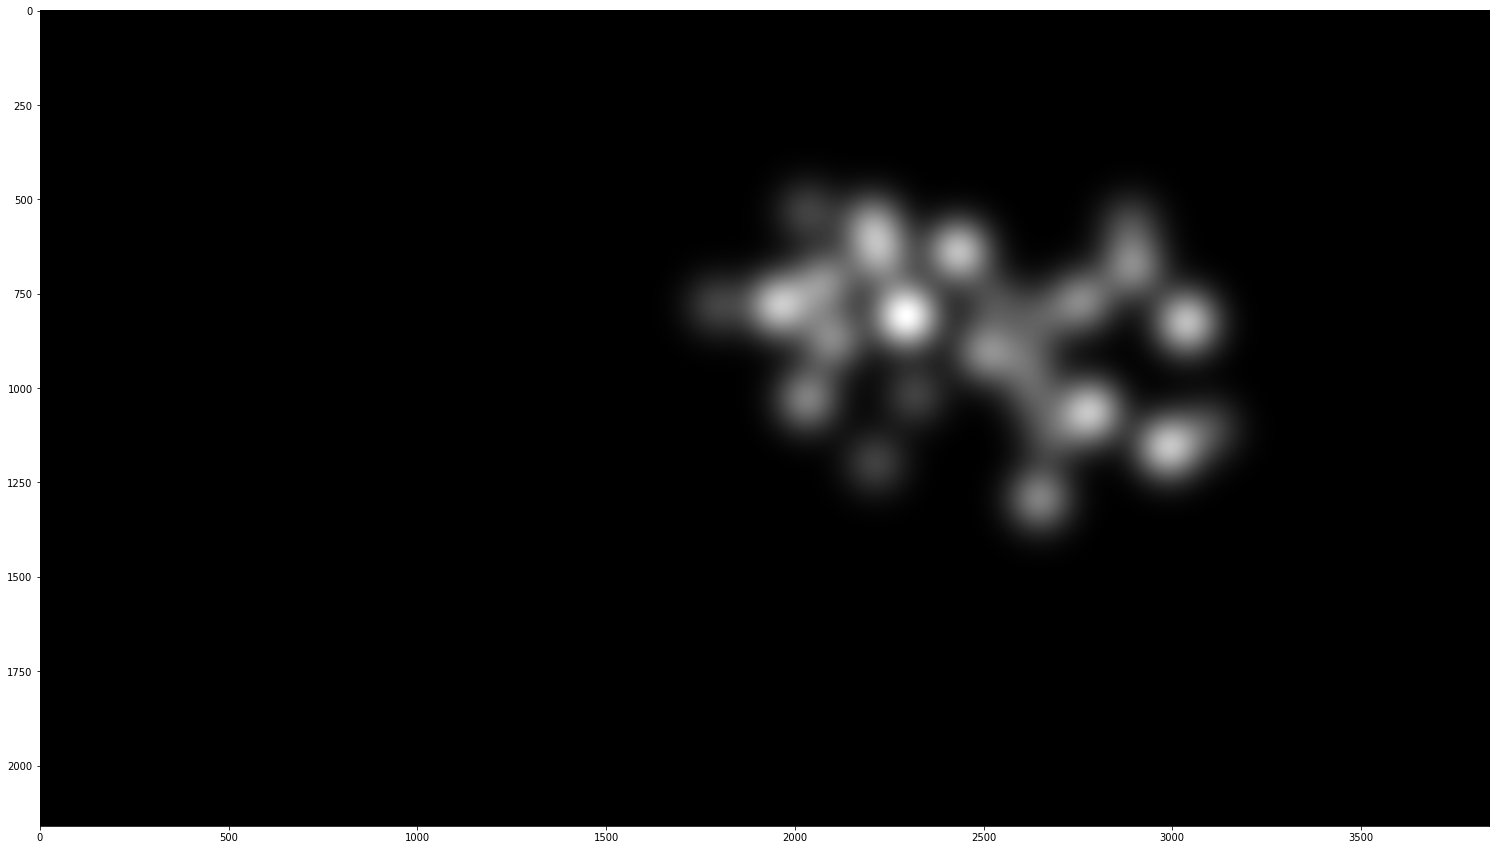

In [12]:
print(density_amount)
mask = resize(mask, (image_original_size[0], image_original_size[1]), mode='constant', preserve_range=True)
mask = gaussian_filter(mask, sigma=density_amount)
plt.figure(figsize=(30, 15))
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
train_data = data_loader.load_train_data('final_data', is_dots_expanded=False, expand_size=1)
test_data = data_loader.load_test_data('final_data', is_dots_expanded=False, expand_size=1)

In [ ]:
show_index = 7
s1 = train_data['train_data'][show_index]
l1 = train_data['train_label_data'][show_index]
lc1 = train_data['train_count_label_data'][show_index]

print(lc1)


plt.figure(figsize=(30, 15))
plt.imshow(s1, cmap='gray')
plt.show()

plt.figure(figsize=(30, 15))
plt.imshow(l1, cmap='gray')
plt.show()

In [ ]:
ls1 = l1.reshape(192, 256)

In [ ]:
ls1.shape

In [ ]:
ls1

In [ ]:
np.sum(ls1)

In [ ]:
lsg1 = gaussian_filter(ls1, sigma=4)
plt.figure(figsize=(30, 15))
plt.imshow(lsg1, cmap='gray')
plt.show()

In [ ]:
np.sum(lsg1)